# Milestone 2
This notebook aims to delve into and elucidate the pertinent aspects of our datasets, pre-process them in advance, and conduct a preliminary analysis. The initial part encompasses loading the data and incorporates various general preprocessing techniques. The subsequent part encapsulate the preliminary analyses conducted, providing insights into the viability and soundness of our chosen idea.

## Contents of notebook:
- [Part 1: Getting Familiar with the Data](#Part-1:-Getting-Familiar-with-the-Data)
    - [Loading the Data](#Loading-the-Data)
    - [Merging the Data](#Merging-the-Data)
- [Part 2: Data Cleaning and Preparation](#Part-2:-Data-Cleaning-and-Preparation)
- [Part 3: Dealing with Columns That Have Multiple Values](#Part-3:-Dealing-with-Columns-That-Have-Multiple-Values)
- [Part 4: Analysis of the Box Office Through the Years](#Part-4:-Analysis-of-the-Box-Office-Through-the-Years)
- [Part 5: The Effect of Inflation](#Part-5:-The-Effect-of-Inflation)
- [Part 6: Weather data analysis](#Part-6:-Weather-data-analysis)

---

## Part 1: Getting Familiar with the Data

In [2]:
import pandas as pd
from datetime import datetime as dt
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import ast
from wordcloud import WordCloud


### Loading the Data

In [4]:
# Dataset Path
movies_path = './data/MovieSummaries/movie.metadata.tsv'

# Column Names
movies_names = [
    "wikipedia_movie_ID",
    "freebase_movie_ID",
    "movie_name",
    "movie_release_date",
    "movie_box_office_revenue",
    "movie_runtime",
    "movie_languages",
    "movie_countries",
    "movie_genres",
]

#Year for the analysis
first_year = 1992
last_year = 2012


# Dataframe
movies_df = pd.read_csv(movies_path, sep = "\t", header = None, names = movies_names)

# Dataframe Cleaning 
movies_df["movie_release_date"] = pd.to_datetime(movies_df["movie_release_date"], errors = "coerce")
movies_df = movies_df[movies_df["movie_release_date"].dt.year.between(first_year, last_year)]


In [3]:
# This function transforms the data in the given input (assumed to be a string containing a dictionary like object) into a list of the values contained in the dictionary like object
def dictionary_string_to_list(input):
    res = []
    for value in (ast.literal_eval(input)).values():
        res += [value]
    return res

# We appply the above function iteratively to the genres, countries and languages columns
movies_df["movie_genres"] = movies_df["movie_genres"].apply(dictionary_string_to_list)

# We also filter to keep only the films that were shown in the USA
movies_df["movie_countries"] = movies_df["movie_countries"].apply(dictionary_string_to_list)
movies_df = movies_df[movies_df['movie_countries'].apply(lambda list : "United States of America" in list)]

movies_df["movie_languages"] = movies_df["movie_languages"].apply(dictionary_string_to_list)

movies_df = movies_df.drop(columns = ["wikipedia_movie_ID", "freebase_movie_ID"])

display(movies_df)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
12,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,..."
21,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie..."
29,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]"
...,...,...,...,...,...,...,...
81678,Confessions of a Sexist Pig,1998-03-07,NaN,91.0,[English Language],[United States of America],"[Romantic comedy, Comedy]"
81684,West 47th Street,2001-03-10,NaN,104.0,[English Language],[United States of America],"[Drama, Documentary]"
81725,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]"
81726,Guilty as Sin,1993-06-04,22886222.0,107.0,[],[United States of America],"[Thriller, Erotic thriller, Psychological thri..."


### Part 2: Get the box office revenue for the USA
We obtain data for the box office revenue from the Watch Mojo website. Then, we load it and merge it to our current dataset.

In [4]:
# Dataset Path
usBoxOffice_path = "./data/boxofficemojo_august_2019.csv"

# Column Names
usBoxOffice_names = [
    "rank",
    "movie_name",
    "studio",
    "domestic_movie_box_office_revenue",
    "year",
]

# Dataframe
usBoxOffice_df = pd.read_csv(usBoxOffice_path, sep = ",", header = 0, names = usBoxOffice_names)

# Dataframe Cleaning
usBoxOffice_df = usBoxOffice_df[usBoxOffice_df["year"].between(first_year, last_year)]
usBoxOffice_df = usBoxOffice_df.drop(columns = ["rank", "year"])

display(usBoxOffice_df)

,movie_name,studio,domestic_movie_box_office_revenue
2,Avatar,Fox,760507625
5,Titanic,Par.,659363944
7,Marvel's The Avengers,BV,623357910
10,The Dark Knight,WB,535234033
14,Star Wars: Episode I - The Phantom Menace,Fox,474544677
...,...,...,...
16530,Playback,Magn.,264
16533,"Pretty Village, Pretty Flame",Wells,211
16536,The Objective,IFC,95
16537,Dog Eat Dog,IFC,80


### Merging the Data
As the Box Office Mojo dataset solely features movie titles without any corresponding identification, we merged it with the CMU Movie Summary Corpus Dataset using the common identifier of movie_name. This merged dataset now incorporates details regarding the U.S. domestic box office revenue, a crucial element for our analytical endeavors.

In [5]:
# Dataframes Merge
movies_df = pd.merge(
    left = movies_df,
    right = usBoxOffice_df,
    how = "left",
    on = ["movie_name"],
)

# We remove the movies that do not have a box office value in the US using the added data
movies_df = movies_df[movies_df["domestic_movie_box_office_revenue"].notna()]

# We also remove movies that do not have any genres, for future analysis
movies_df = movies_df.drop(movies_df[movies_df['movie_genres'].apply(lambda input: len(input)) == 0].index)

display(movies_df)

,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,studio,domestic_movie_box_office_revenue
3,New Rose Hotel,1999-10-01,21521.0,92.0,[English Language],[United States of America],"[Thriller, Science Fiction, Future noir, Indie...",Lions,21521.0
4,Baby Boy,2001-06-27,29381649.0,123.0,[English Language],[United States of America],"[Crime Fiction, Drama, Coming of age]",Sony,28734552.0
5,The Great New Wonderful,2006-06-23,172055.0,87.0,[English Language],[United States of America],"[Drama, Ensemble Film, Comedy-drama, Indie]",FInd.,150142.0
11,The Bridge,2006-09-01,NaN,69.0,[English Language],[United States of America],[Drama],FStr.,179780.0
12,The Astronaut Farmer,2006-10-15,11130889.0,104.0,"[English Language, Spanish Language]",[United States of America],"[Science Fiction, Americana, Drama, Adventure,...",WB,11003643.0
...,...,...,...,...,...,...,...,...,...
8446,Twister,1996-05-10,494471524.0,113.0,[English Language],[United States of America],"[Action/Adventure, Disaster]",WB,241721524.0
8447,Source Code,2011-03-11,147332697.0,93.0,[English Language],"[France, United States of America]","[Thriller, Science Fiction, Action/Adventure, ...",Sum.,54712227.0
8448,How to Eat Fried Worms,2006-08-25,13040527.0,98.0,[English Language],[United States of America],"[Family Film, Drama, Comedy, Film adaptation]",NL,13040527.0
8451,State and Main,2000-08-26,6944471.0,106.0,"[Italian Language, English Language]","[France, United States of America]","[Parody, Americana, Comedy]",FL,6944471.0


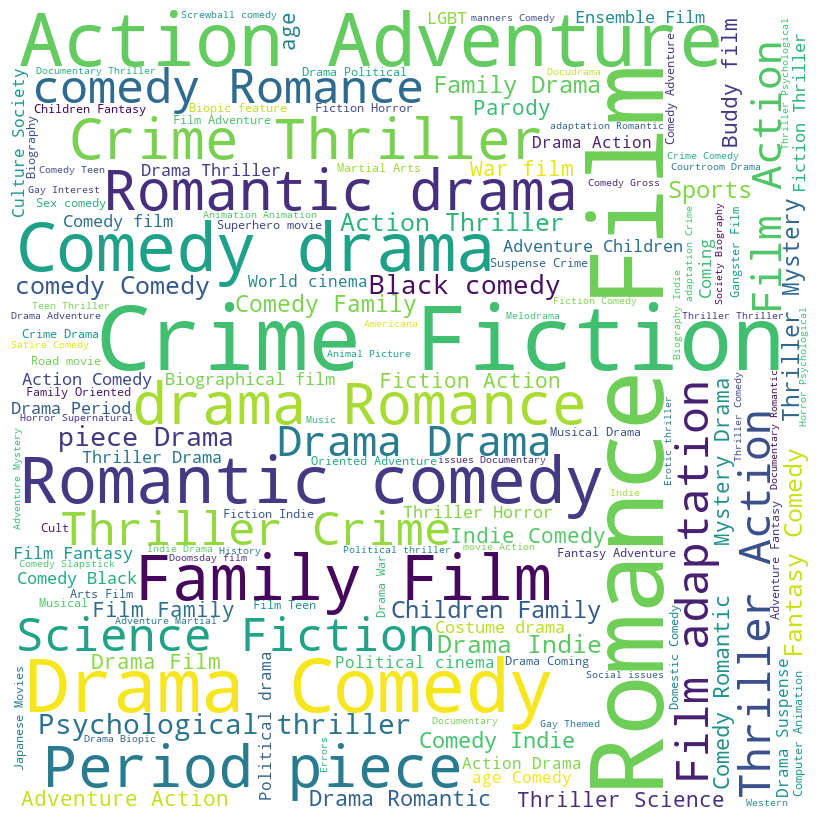

In [6]:
all_genres = ' '.join([' '.join(genres) for genres in movies_df['movie_genres'].dropna()])

# Create a WordCloud object
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      stopwords = None, 
                      min_font_size = 10).generate(all_genres)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Part 3: Dealing with columns that have multiple values
Then, we create a dataframe handling the genres, countries and languages columns in the data, in order to make them easier to handle in the future. This is achieved by creating a 'dummy' version for each of these variables.

In [7]:
# We need to define the dummy variables not for each possible list containing genres, but for genres within said lists. This function handles this added layer. 

def define_dummy_variables(df, column):
    # Exploding the specified column
    s = df[column].explode()
    # Creating dummy variables
    dummies = pd.get_dummies(s)
    # Summing the dummy variables for each original index
    result = dummies.groupby(dummies.index).sum()
    return result

Genres_df = define_dummy_variables(movies_df, 'movie_genres')
Countries_df = define_dummy_variables(movies_df, 'movie_countries')
Language_df = define_dummy_variables(movies_df, 'movie_languages')

However, we notice that there are far too many sub-genres here, many of which can be aggregated in overarching genres (such as "acid western" and "western", or any other kind of westerns). 
To do so, we choose keywords representing our selected genres (which represent the largest part of our dataset) and will aggregate any columns containing one of the keyword in this genre. 
To give a clear example, a comedy drama will indicate a comedy and a drama. As such, it will count for both. Also, to keep our variables here as 'dummy' we do not count multiple times occurences of any genres (i.e a movie that is both a comedy drama and a comedy doesn't have a '2' for the value in the column comedy, only a 1 showing that it is indeed a comedy).

In [8]:
# Initialize an empty DataFrame to store aggregated genres
Genres_aggregated_df = pd.DataFrame(index=Genres_df.index)

# Add 'Documentary' column from Genres_df to Genres_aggregated_df
Genres_aggregated_df['Documentary'] = Genres_df['Documentary'].copy()   

# Define the aggregation method
aggregation_method = {
    'Western': ['Western'],
    'Action': ['Action'],
    'Comedy': ['Comedy'],
    'Thrillers': ['Thrillers'],
    'Adventure': ['Adventure'],
    'Drama': ['Drama'],
    'Musical': ['Musical'],
    'Animation': ['Animated', 'Anime', 'Animation'],
    'History': ['Archive', 'History'],
    'Biography': ['Biopic', 'Biographical', 'Biography'],
    'Sports': ['Sports'],
    'Fantasy': ['Fantasy'],
    'Indie': ['Indie'],
    'Mystery': ['Mystery', 'Crime'],
    'Parody': ['Satire', 'Parody'],
    'Romance': ['Romantic', 'Romance'],
    'Science Fiction': ['Sci-Fi', 'Science Fiction'],
    'Family': ['Family'],
    'Short film': ['Short Film']
}

# Iterate over the aggregation method to populate the new DataFrame
for genre, keywords in aggregation_method.items():
    # Use DataFrame filter to select columns matching the keywords
    columns_matching_keywords = Genres_df.filter(regex='|'.join(keywords))
    # Aggregate using max and assign to the new DataFrame
    Genres_aggregated_df[genre] = columns_matching_keywords.max(axis=1)

# Display the first 20 rows
Genres_aggregated_df.head(20)

,Documentary,Western,Action,Comedy,Thrillers,Adventure,Drama,Musical,Animation,History,Biography,Sports,Fantasy,Indie,Mystery,Parody,Romance,Science Fiction,Family,Short film
3,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
11,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0
14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
20,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
21,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


### Analysis on the genres repartition in the dataset
We now analyze how the genres are represented in the dataset, and if some types of movies are overly represented. We also print some values to get a quantitative sense of the genre distribution.

<Axes: >

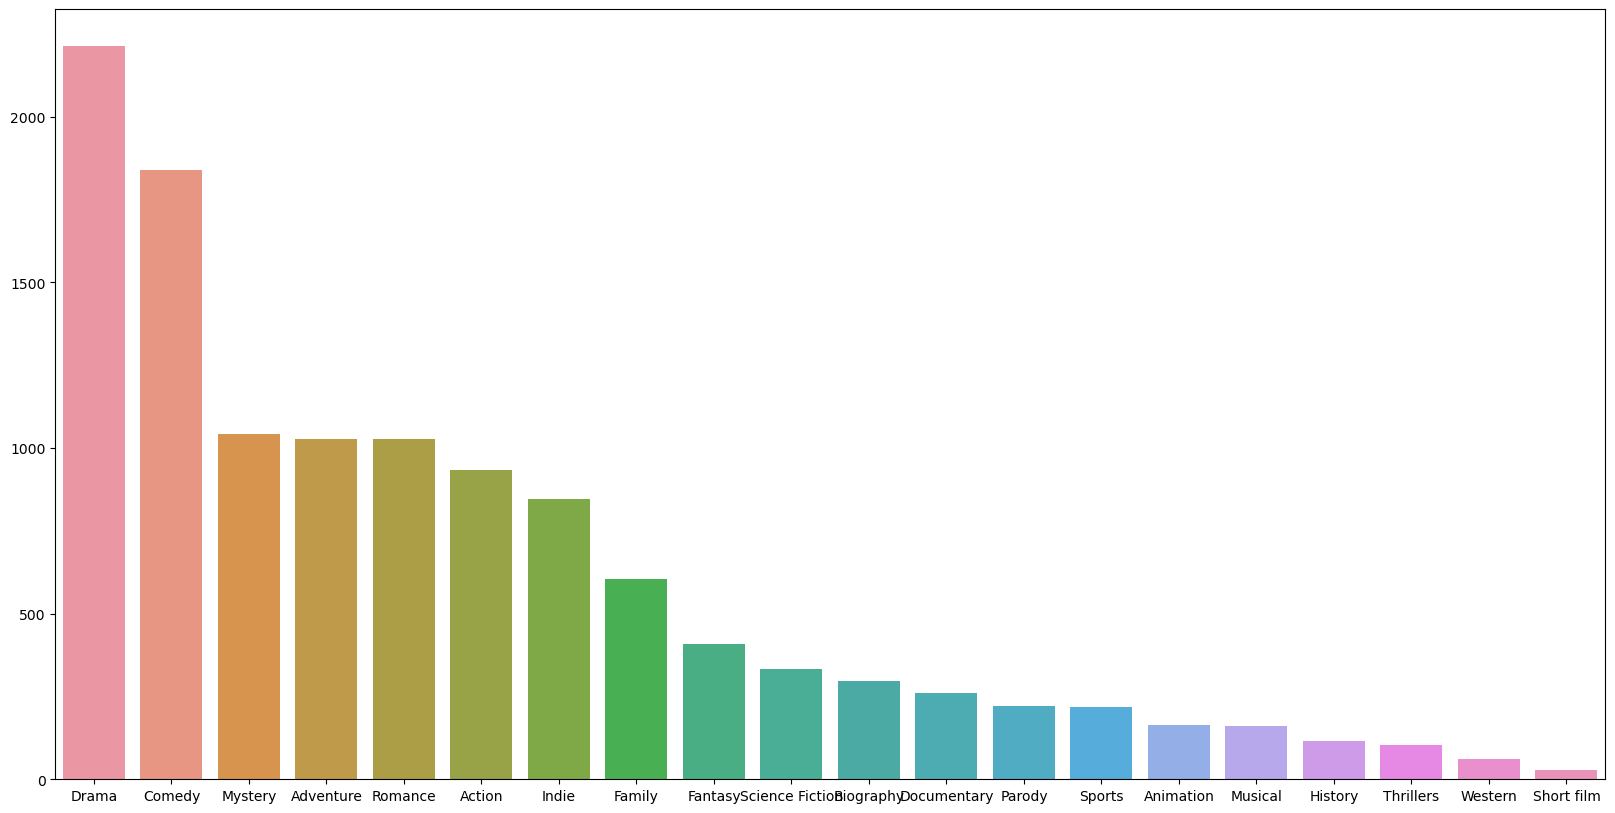

In [9]:
sums = Genres_aggregated_df.sum(axis=0).sort_values(ascending=False)

indexes = sums.index
counts = list(sums.values)
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x = indexes, y = counts)

In [10]:
# We then print some values to see what proportions of movies belong to each categories, in descending order
num_movies = Genres_aggregated_df.shape[0]
print('Percentages of movies belonging to each genres :')
for genre in indexes:
    print(genre, f'{round(sums[genre]/num_movies*100, 2)}%')

print('\n')   
#We then see what proportions of movie are left without any genres to fit into
print(f'There are {round((1-Genres_aggregated_df.max(axis="columns").sum()/num_movies) * 100, 2)}% of movies left in our dataset that do not have any genres left')

Percentages of movies belonging to each genres :
Drama 53.02%
Comedy 44.06%
Mystery 24.95%
Adventure 24.62%
Romance 24.59%
Action 22.37%
Indie 20.26%
Family 14.51%
Fantasy 9.77%
Science Fiction 7.95%
Biography 7.14%
Documentary 6.23%
Parody 5.27%
Sports 5.24%
Animation 3.9%
Musical 3.88%
History 2.8%
Thrillers 2.47%
Western 1.48%
Short film 0.67%


There are 2.2% of movies left in our dataset that do not have any genres left


## Part 4: Analysis of the box office through the years
We take a look at what the revenue distribution for movie looks like for our filtered dataset. 

In [11]:
stats = movies_df['domestic_movie_box_office_revenue'].describe()
    
# Print the statistics
print(" Box office descriptive Statistics:")
print(stats)

 Box office descriptive Statistics:
count    4.176000e+03
mean     3.424259e+07
std      5.685523e+07
min      3.000000e+01
25%      8.722245e+05
50%      1.335949e+07
75%      4.186543e+07
max      7.605076e+08
Name: domestic_movie_box_office_revenue, dtype: float64


[Text(0.5, 1.0, 'Revenue distribution')]

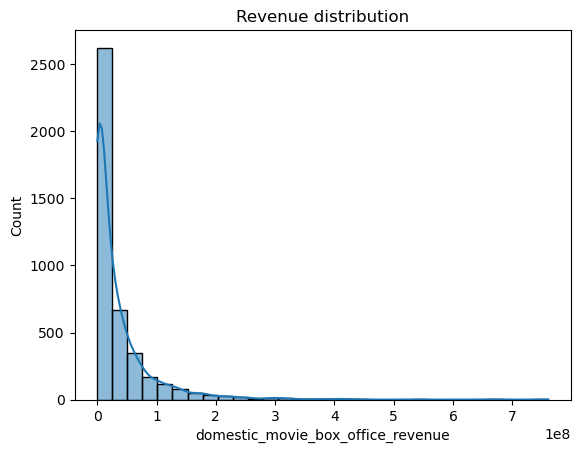

In [12]:
# Compute the distribution for our movie datasets in terms of box office revenues
sns.histplot(movies_df["domestic_movie_box_office_revenue"], bins=30, kde=True).set(title = 'Revenue distribution')


However, we see that our distribution is extremely skewed : we have a long tailed distribution. As such, it seems interesting to take a look at our data using a log plot for our x-axis to get a better idea of the way movies are spread in terms of revenues. 

[Text(0.5, 1.0, 'Revenue distribution')]

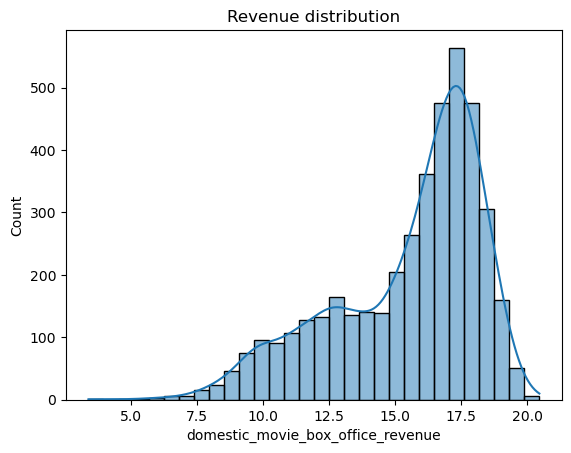

In [13]:
#PLot the distribution for the log normalized box offices 
sns.histplot(np.log(movies_df["domestic_movie_box_office_revenue"]), bins=30, kde=True).set(title = 'Revenue distribution')


In [14]:
# Describe the box office revenue per year
for year in range(first_year, last_year+1):
    # Calculate descriptive statistics for each column
    stats = movies_df[movies_df["movie_release_date"].dt.year == year]["domestic_movie_box_office_revenue"].describe()
    
    # Print the statistics
    print(f"{year} Descriptive Statistics:")
    print(stats)
    print("\n" + "-"*65 + "\n")

1992 Descriptive Statistics:
count    1.320000e+02
mean     3.189697e+07
std      4.066676e+07
min      2.019400e+04
25%      4.367301e+06
50%      1.711074e+07
75%      4.579222e+07
max      2.173502e+08
Name: domestic_movie_box_office_revenue, dtype: float64

-----------------------------------------------------------------

1993 Descriptive Statistics:
count    1.460000e+02
mean     2.838626e+07
std      4.601484e+07
min      2.142900e+04
25%      5.101638e+06
50%      1.344150e+07
75%      3.558325e+07
max      4.028281e+08
Name: domestic_movie_box_office_revenue, dtype: float64

-----------------------------------------------------------------

1994 Descriptive Statistics:
count    1.540000e+02
mean     2.832364e+07
std      5.089071e+07
min      1.166900e+04
25%      3.692595e+06
50%      1.424300e+07
75%      3.047248e+07
max      4.227838e+08
Name: domestic_movie_box_office_revenue, dtype: float64

-----------------------------------------------------------------

1995 Descript

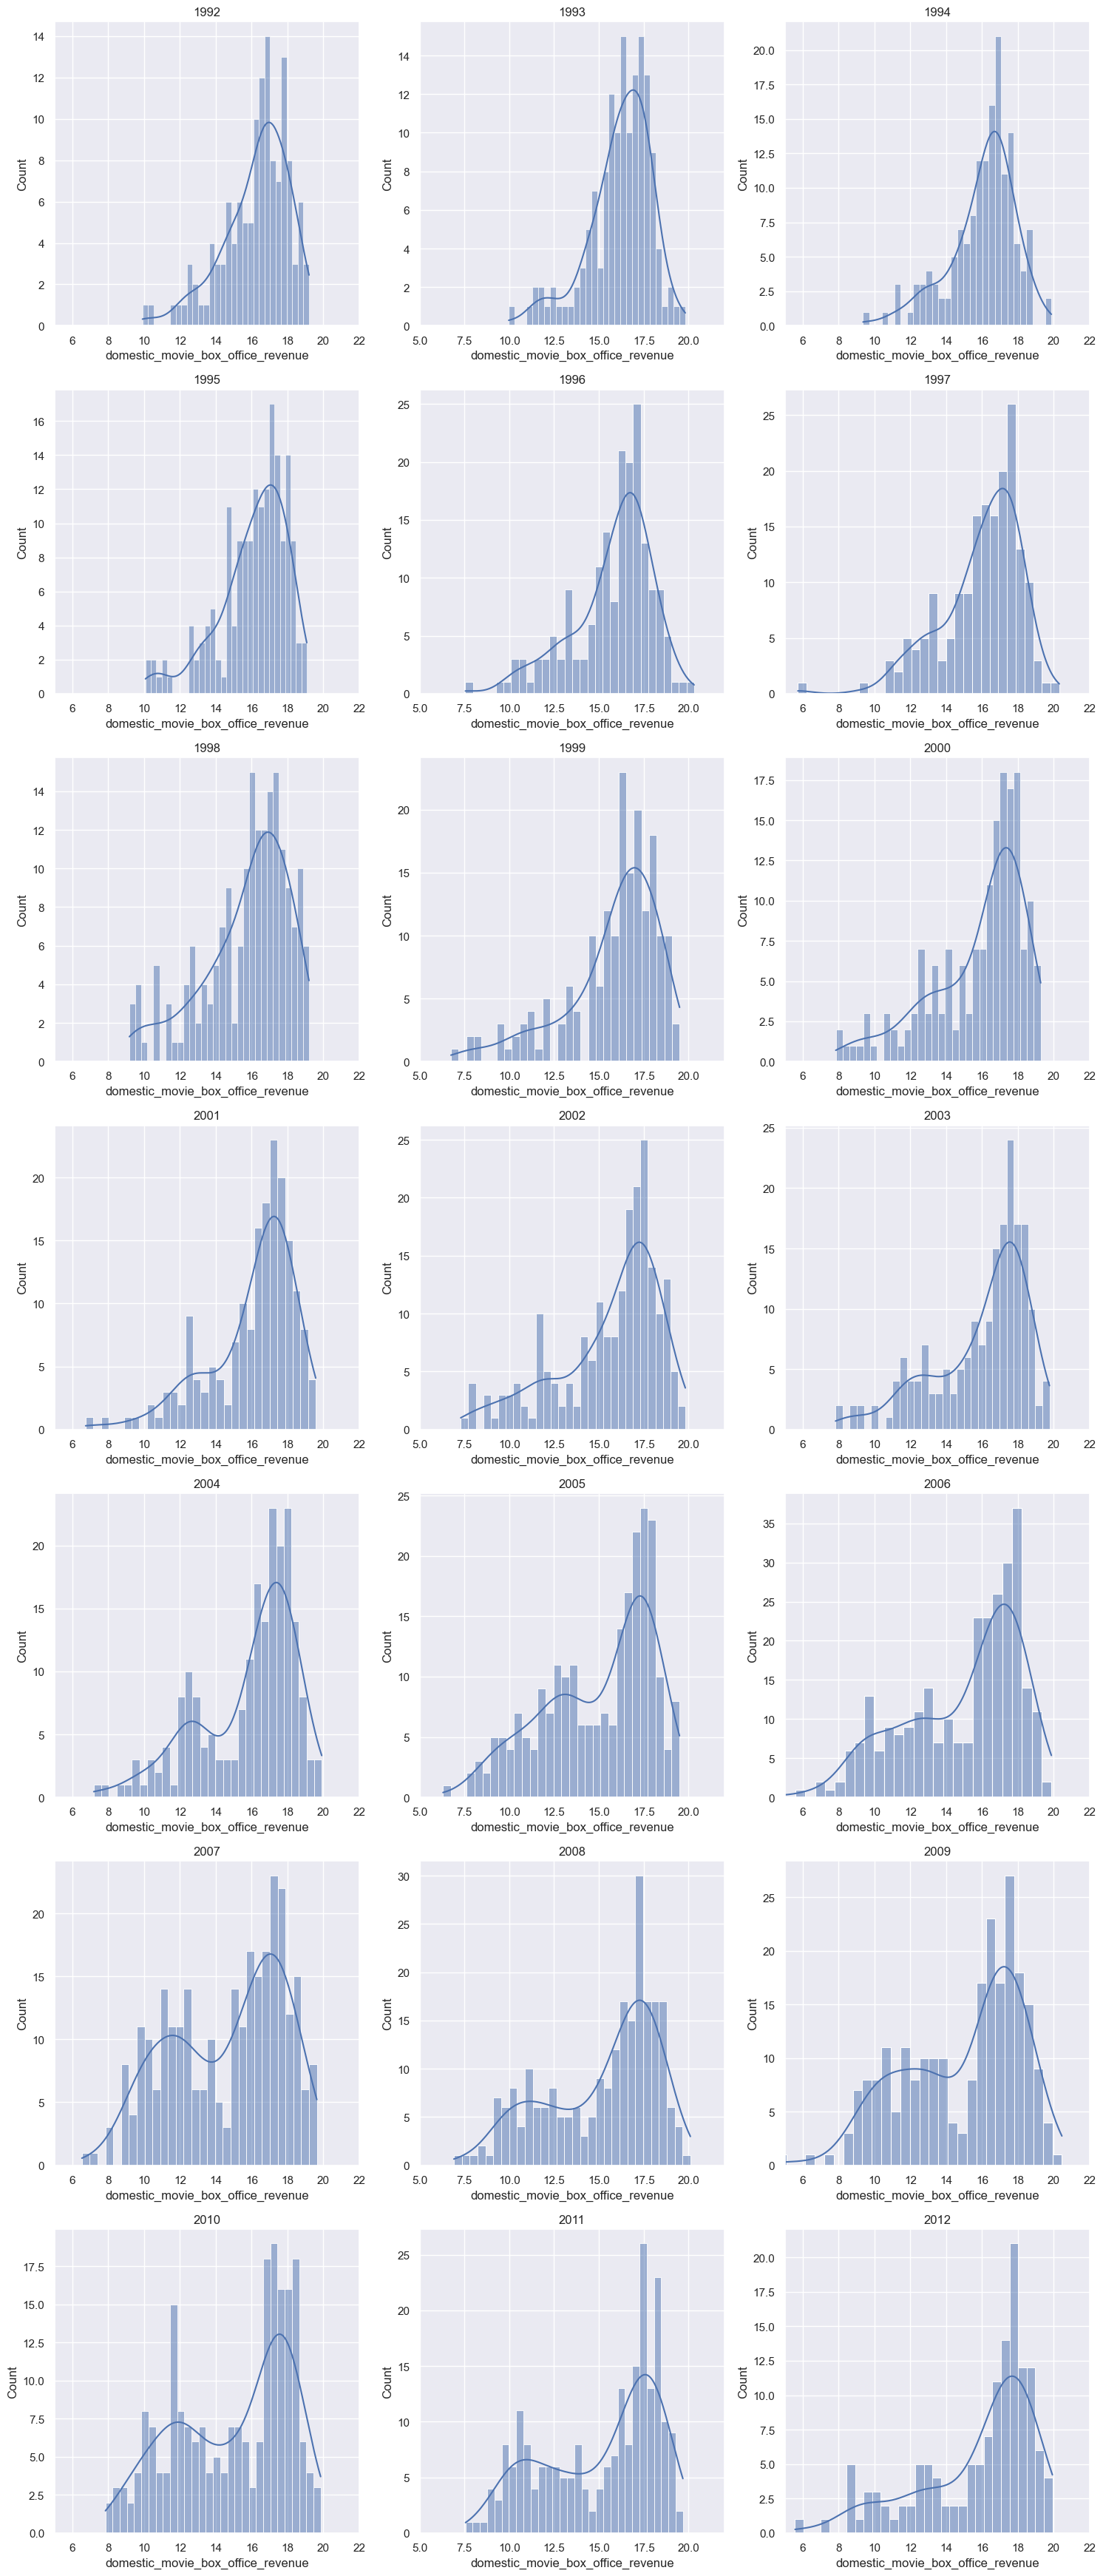

In [15]:
sns.set(style="darkgrid")


# We have 21 years of data for our choice of analysis, so we showcase 3 years per row
n_rows = 7
n_cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Plot the box office distribution for each year of our analysis
for year in range(first_year, last_year + 1):
    position = year - first_year
    row = position//3
    col = position%3
    ax = axes[row, col]
    ax.set_xlim(5,22)
    
    sns.histplot(np.log(movies_df[movies_df["movie_release_date"].dt.year == year]["domestic_movie_box_office_revenue"]), bins=30, ax=ax, kde=True)
    ax.set_title(f'{year}')

plt.tight_layout()
plt.show()

## Part 5 : The effect of inflation
We notice that, overall, the mean tends to increase throughout the year. The issue currently is that this analysis does not factor in the inflation rate, which means that the data is skewed for older movies. To correct this effect, we add a column to our dataset to include the inflation corrected box offices.
There is no perfect method to account for this inflation rate, as many elements must be considered (prices of the tickets vs the inflation rate namely, types of tickets used and so on). The method selected here is to use the mean inflation rate between the release year X and the year 2012 (since this is the last year of our dataset). In practice, this corresponds to what a dollar in year X would be worth in 2012.


In [16]:
inflation_rates_df = pd.read_csv('./data/Inflation rate.csv', index_col='Year', sep=';', decimal=',')

# This function allow us to get the inflation rate for a given year
def get_inflation_rate(year):
    return inflation_rates_df.loc[year]['Factor']

# Multiply the inflation rate for the release year by the box office to compute the inflation corrected value
movies_df['Inflation_corrected_box_office'] = movies_df['movie_release_date'].dt.year.apply(get_inflation_rate) * movies_df['domestic_movie_box_office_revenue']

With this new column, we repeat the analysis from before to get a better idea of the actual box office distribution

In [17]:
stats = movies_df['Inflation_corrected_box_office'].describe()
    
# Print the statistics
print(" Box office descriptive Statistics:")
print(stats)

 Box office descriptive Statistics:
count    4.176000e+03
mean     4.325560e+07
std      7.113763e+07
min      3.480000e+01
25%      1.056844e+06
50%      1.746382e+07
75%      5.363754e+07
max      9.824523e+08
Name: Inflation_corrected_box_office, dtype: float64


[Text(0.5, 1.0, 'Inflation corrected revenue distribution')]

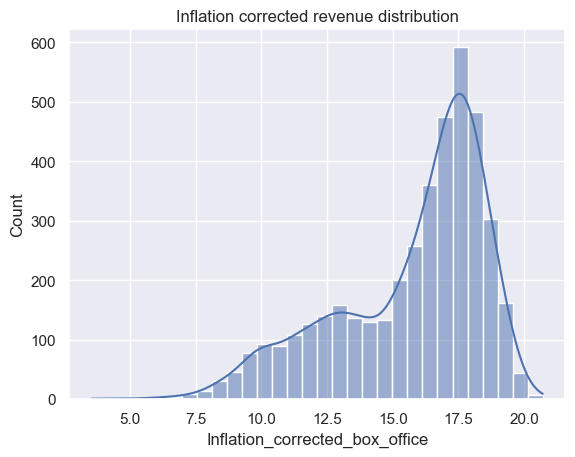

In [18]:
# Compute the distribution for our movie datasets in terms of box office revenues
sns.histplot(np.log(movies_df["Inflation_corrected_box_office"]), bins=30, kde=True).set(title = 'Inflation corrected revenue distribution')


In [19]:
# Describe the box office revenue corrected for inflation per year
for year in range(first_year, last_year+1):
    # Calculate descriptive statistics for each column
    stats = movies_df[movies_df["movie_release_date"].dt.year == year]["Inflation_corrected_box_office"].describe()
    
    # Print the statistics
    print(f"{year} Descriptive Statistics:")
    print(stats)
    print("\n" + "-"*65 + "\n")

1992 Descriptive Statistics:
count    1.320000e+02
mean     5.294897e+07
std      6.750683e+07
min      3.352204e+04
25%      7.249719e+06
50%      2.840383e+07
75%      7.601509e+07
max      3.608014e+08
Name: Inflation_corrected_box_office, dtype: float64

-----------------------------------------------------------------

1993 Descriptive Statistics:
count    1.460000e+02
mean     4.570188e+07
std      7.408390e+07
min      3.450069e+04
25%      8.213636e+06
50%      2.164081e+07
75%      5.728904e+07
max      6.485533e+08
Name: Inflation_corrected_box_office, dtype: float64

-----------------------------------------------------------------

1994 Descriptive Statistics:
count    1.540000e+02
mean     4.446812e+07
std      7.989841e+07
min      1.832033e+04
25%      5.797374e+06
50%      2.236151e+07
75%      4.784179e+07
max      6.637705e+08
Name: Inflation_corrected_box_office, dtype: float64

-----------------------------------------------------------------

1995 Descriptive Stati

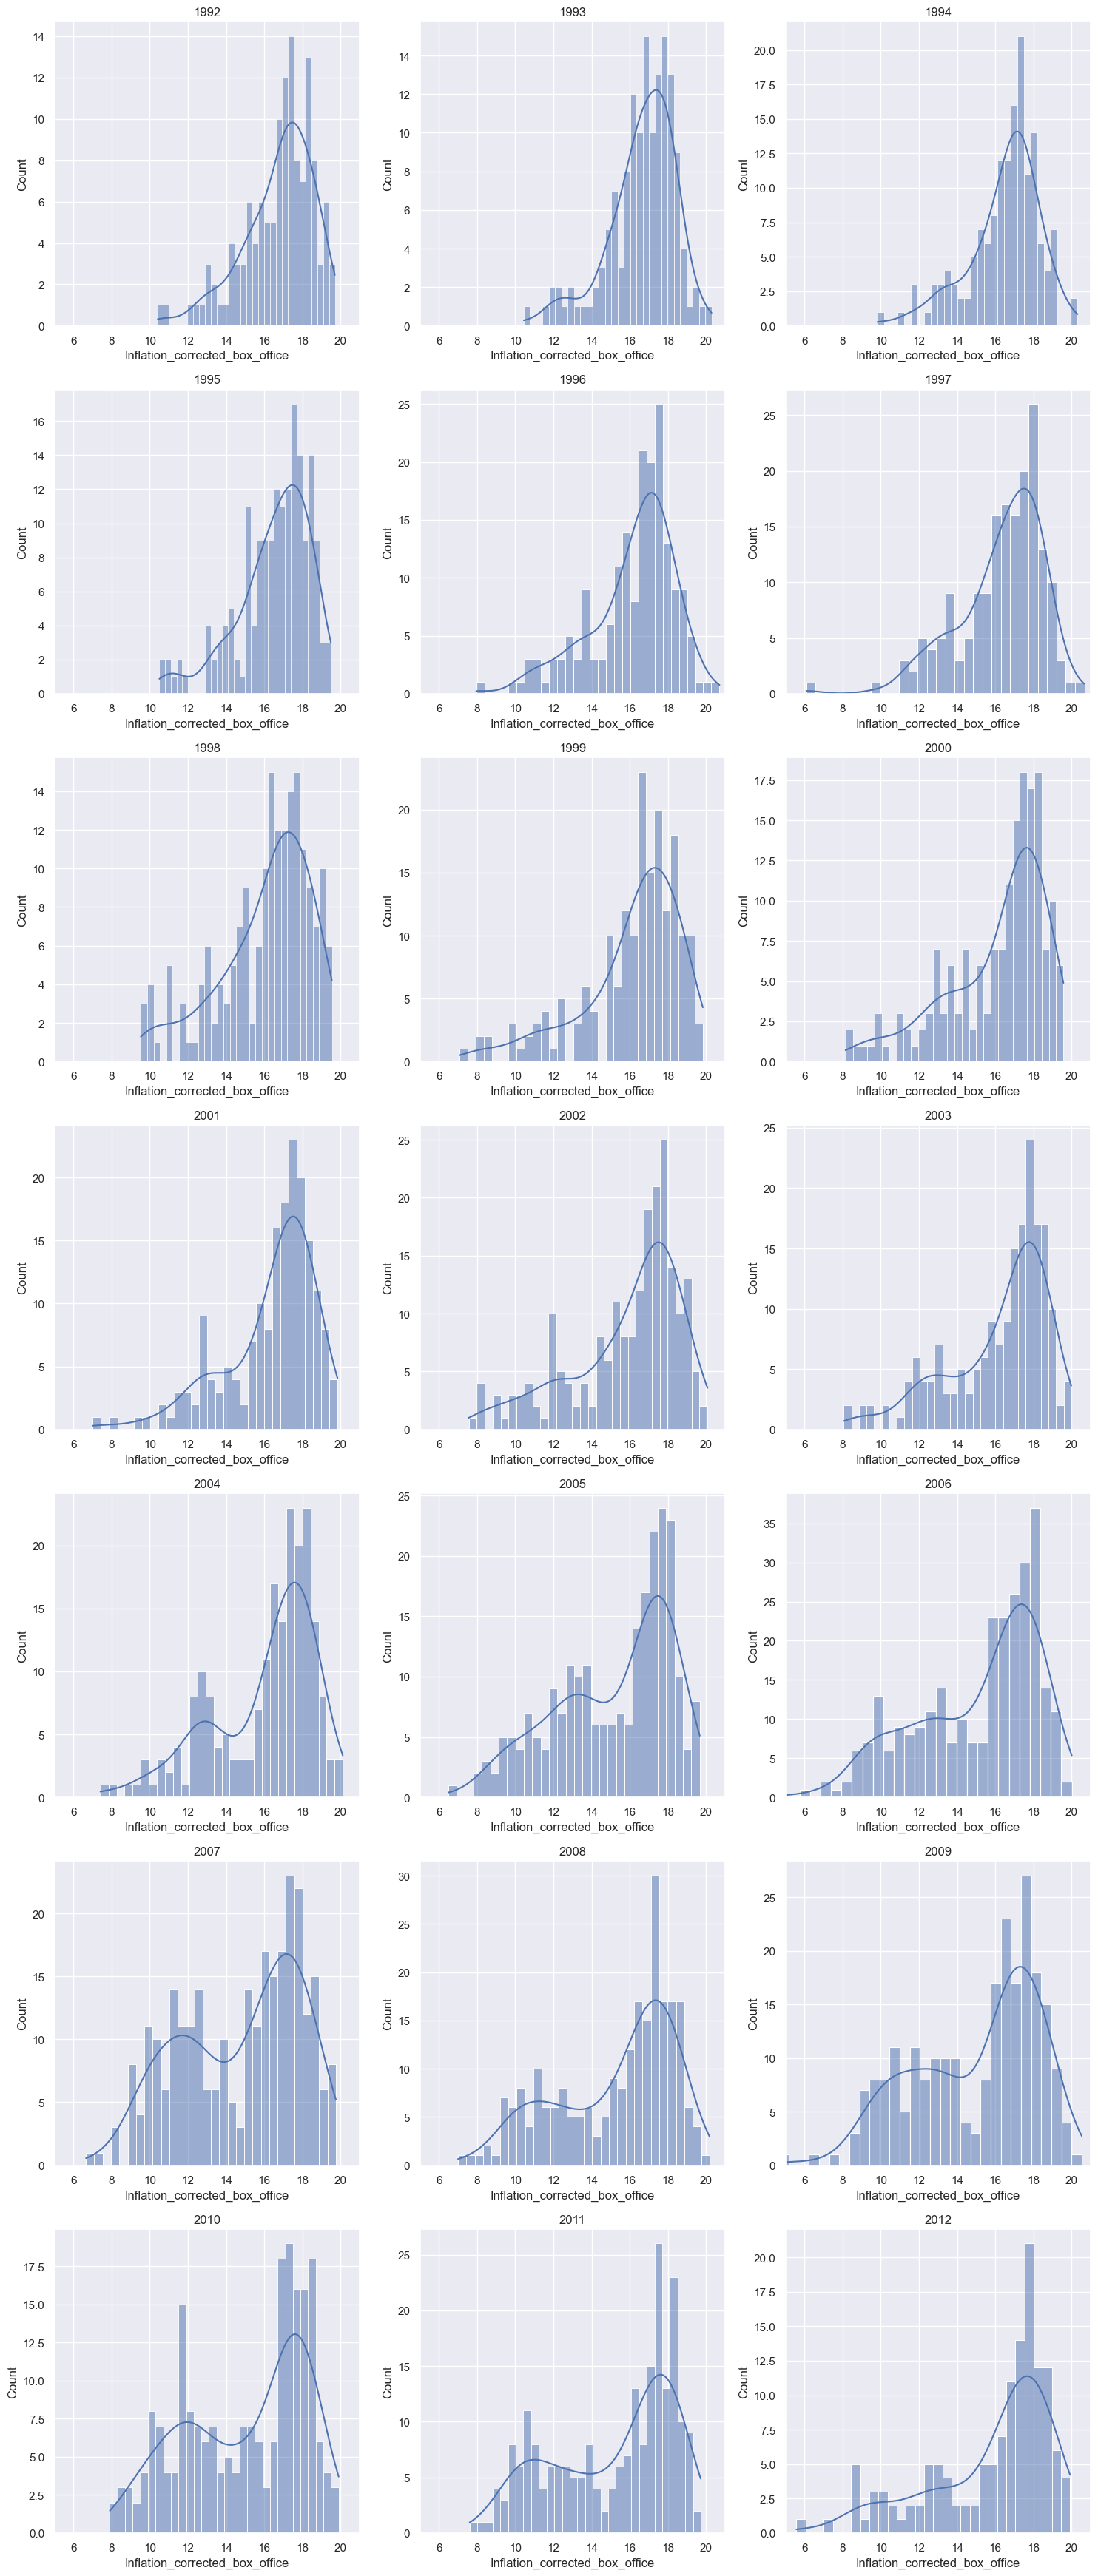

In [20]:
sns.set(style="darkgrid")


# We have 21 years of data for our choice of analysis, so we showcase 3 years per row
n_rows = 7
n_cols = 3

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Plot the box office distribution for each year of our analysis
for year in range(first_year, last_year + 1):
    position = year - first_year
    row = position//3
    col = position%3
    ax = axes[row, col]
    ax.set_xlim(5,21)
    
    sns.histplot(np.log(movies_df[movies_df["movie_release_date"].dt.year == year]["Inflation_corrected_box_office"]), bins=30, ax=ax, kde=True)
    ax.set_title(f'{year}')

plt.tight_layout()
plt.show()

### Part 6: Weather data analysis
Now that we have cleaned the data from the CMU movies dataset, we must add and clean the data regarding weather in the selected cities. 

In [ ]:
path = './data/Weather'

chicago = pd.read_csv(path + '/Chicago.csv')
new_york = pd.read_csv(path + '/NewYork.csv')
washington = pd.read_csv(path + '/WashingtonDC.csv')
dallas = pd.read_csv(path + '/Dallas.csv')
la = pd.read_csv(path + '/LosAngeles.csv')
miami = pd.read_csv(path + '/Miami.csv')
seattle = pd.read_csv(path + '/Seattle.csv')
atlanta = pd.read_csv(path + '/Atlanta.csv')

#make a copy of the original data and call them city_copy

chicago_copy = chicago.copy()   
new_york_copy = new_york.copy()
washington_copy = washington.copy()
dallas_copy = dallas.copy()
la_copy = la.copy()
miami_copy = miami.copy()
seattle_copy = seattle.copy()

la_copy.head()  

In [ ]:
def keep_columns (df):
    df = df.copy()  
    df = df[['DATE', 'PRCP', 'SNOW', 'TMAX', 'TMIN']]
    df['DATE'] = pd.to_datetime(df['DATE'])  # Convert 'DATE' to datetime
    df.set_index('DATE', inplace=True)
    
    return df

# Data Preparation

### 1) Selecting data based on years from 1992 to 2012
##### The dataset of movie releases from CMU includes data up to the year 2012. To align our weather data analysis with this period, we'll match the same timeframe. Given that our starting point is 2012, we'll go back 20 years, which brings us to the year 1992. Thus, we'll consider weather data spanning from 1992 to 2012 for our analysis, ensuring it corresponds with the time range covered by the CMU movie releases dataset.

In [ ]:
cities = ['chicago', 'new_york', 'washington', 'dallas', 'la', 'miami', 'seattle', 'atlanta']

for city in cities:
    globals()[city] = keep_columns(globals()[city])

for city in cities:
    first_date = globals()[city].index.min()
    last_date = globals()[city].index.max()
    print(f"{city.title()}: First Date - {first_date}, Last Date - {last_date}")

In [ ]:
start_date = pd.to_datetime(f'{1992}-01-01')
end_date = pd.to_datetime(f'{2012}-12-31')

for city in cities:
    # Filter the dataframe based on the date range
    globals()[city] = globals()[city][(globals()[city].index >= start_date) & (globals()[city].index <= end_date)]

### 2 ) Adjusting temperatures 
In the original dataset, the max and min temperatures are actually tenth of the real temperatures, so we will have to adapt them, and convert them to Celsius.

In [ ]:
for city in cities:
    # Convert temperature columns to Celsius
    globals()[city]['TMIN'] = globals()[city]['TMIN'] / 10
    globals()[city] = globals()[city].rename(columns={'TMIN': 'TMIN (°C)'})
    
    globals()[city]['TMAX'] = globals()[city]['TMAX'] / 10
    globals()[city] = globals()[city].rename(columns={'TMAX': 'TMAX (°C)'})
    
    globals()[city] = globals()[city].rename(columns={'PRCP': 'PRCP (mm)'})

### 3) Handling Missing data
##### Now, we add some plot to get an idea of the missing data in our current dataset. Then, depending on the results, we will deal with the missing values.

In [ ]:
# Determine the layout of the subplots
n_rows = 2  # Adjust as needed
n_cols = (len(cities) + 1) // 2  # Adjust to fit all cities

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
fig.tight_layout(pad=4.0, h_pad=8.0)  # Adjust h_pad to add space between rows

# Flatten the axes array for easy iteration if it's 2D
axes = axes.flatten()

for i, city in enumerate(cities):
    # Plot missing values matrix using missingno
    msno.matrix(globals()[city], ax=axes[i])
    axes[i].set_title(f'{city.title()} Missing Values Matrix')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()

In [ ]:
for city in cities:
    # Count missing values for each column in the current city
    missing_counts = globals()[city].isnull().sum()

    # Display missing value counts for the current city
    print(f'{city.title()} Missing Value Counts:')
    print(missing_counts)
    print('\n' + '-'*30 + '\n')  

#### As we can see that in most datasets, the snow column has the most missing values especially in Los Angeles and Seattle. This comes from the fact that cities with warm weather don't have snow so the entries in the datasets are missing, we therefor fill them with 0. As for the temperature and the precipitation, we fill them using the average the immediate neighbours of each missing value. 

In [ ]:
for city in cities:
    # Fill missing values in snow using forward fill
    globals()[city]['SNOW'].fillna(0, inplace=True)
    
    # Fill missing values in TMAX and TMIN using interpolation
    globals()[city]['TMAX (°C)'].interpolate(method='linear', inplace=True)
    globals()[city]['TMIN (°C)'].interpolate(method='linear', inplace=True)
    
    # Fill missing values in PRCP using forward fill
    globals()[city]['PRCP (mm)'].interpolate(method='linear', inplace=True)


### Missing values after handling them 
As we can see in the following cell, there are no missing values anymore. 

In [ ]:
# Determine the layout of the subplots
n_rows = 2  # Adjust as needed
n_cols = (len(cities) + 1) // 2  # Adjust to fit all cities

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
fig.tight_layout(pad=4.0, h_pad=8.0)  # Adjust h_pad to add space between rows

# Flatten the axes array for easy iteration if it's 2D
axes = axes.flatten()

for i, city in enumerate(cities):
    # Plot missing values matrix using missingno
    msno.matrix(globals()[city], ax=axes[i])
    axes[i].set_title(f'{city.title()} Missing Values Matrix')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Show the plot
plt.show()

In [ ]:
for city in cities:
    # Calculate descriptive statistics for each column
    stats = globals()[city].describe()
    
    # Print the statistics
    print(f"{city.title()} Descriptive Statistics:")
    print(stats)
    print("\n" + "-"*65 + "\n")
    

### Creating average temperature column
We now create a composite average temperature using the formula described in the method section. 

In [ ]:
for city in cities:
    globals()[city]['Tavg (°C)'] = globals()[city]['TMIN (°C)'] * (1/3) + globals()[city]['TMAX (°C)'] * (2/3)

sns.set(style="darkgrid")

# Features to plot
features = ['PRCP (mm)', 'TMIN (°C)', 'TMAX (°C)', 'Tavg (°C)']

# Define the number of rows and columns based on the number of cities and features
n_rows = len(cities)
n_cols = len(features)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

for i, city in enumerate(cities):
    df = globals()[city]
    for j, feature in enumerate(features):
        # Determine the correct axis based on the city and feature
        if n_rows > 1:
            ax = axes[i, j]
        else:
            ax = axes[j]

        sns.histplot(df[feature], bins=20, ax=ax, kde=True)
        ax.set_title(f'{city.title()} - {feature}')

plt.tight_layout()
plt.show()


##### The analysis of the datasets reveals several important discrepancies:

##### 1) The reported precipitation values also raise concerns about their accuracy, particularly regarding the maximum amounts recorded. For instance, in New York, the maximum recorded precipitation is 1923 mm, which is inconsistent with the known record for the most precipitation in a 24-hour period. This record was set in Alvin, Texas, on July 25-26, 1979, with a total of 1,077 mm (42.32 inches) of rain. These discrepancies in precipitation data are likely due to measurement errors, and thus, careful handling and validation of such data are essential.

# Handling outliers 
 In this section we will get rid of the outliers as they have no real life meaning. For that we would use the previous records mentionned: 
   1) ELiminate the precipipation higher than 1077 mm. 

In [ ]:
max_precip_mm = 1077  # Maximum precipitation in millimeters

for city in cities:
    # Convert temperature from Fahrenheit to Celsius
    df = globals()[city]

    # Filter out precipitation outliers
    df = df[df['PRCP (mm)'] <= max_precip_mm]


    # Update the global variable
    globals()[city] = df

### Plot of the data after removing outliers

In [ ]:
sns.set(style="darkgrid")

# Features to plot
features = ['PRCP (mm)', 'TMIN (°C)', 'TMAX (°C)', 'Tavg (°C)']

# Define the number of rows and columns based on the number of cities and features
n_rows = len(cities)
n_cols = len(features)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

for i, city in enumerate(cities):
    df = globals()[city]
    for j, feature in enumerate(features):
        # Determine the correct axis based on the city and feature
        if n_rows > 1:
            ax = axes[i, j]
        else:
            ax = axes[j]

        sns.histplot(df[feature], bins=20, ax=ax, kde=True)
        ax.set_title(f'{city.title()} - {feature}')

plt.tight_layout()
plt.show()

In [ ]:
for city in cities:
    stats = globals()[city].describe()
    
    print(f"{city.title()} Descriptive Statistics:")
    print(stats)
    print("\n" + "-"*50 + "\n")

la.head()

## Overall data description and visualization 

In [ ]:
# Create subplots
fig, axes = plt.subplots(nrows=len(cities), ncols=3, figsize=(15, 3 * len(cities)))

for i, city in enumerate(cities):
    # Select relevant columns
    selected_columns = [ 'TMAX (°C)', 'TMIN (°C)', 'Tavg (°C)']
    
    # Calculate mean, min, and max values
    mean_values = globals()[city][selected_columns].mean()
    min_values = globals()[city][selected_columns].min()
    max_values = globals()[city][selected_columns].max()

    # Plot mean values using Seaborn barplot
    sns.barplot(x=mean_values.index, y=mean_values.values, ax=axes[i, 0], color='blue', alpha=0.7)
    axes[i, 0].set_title(f'{city.title()} - Mean Temperature')
    axes[i, 0].set_ylabel(city.title(), rotation=0, labelpad=30, ha='right')  # Add city name to the left
    
    # Plot min values using Seaborn barplot
    sns.barplot(x=min_values.index, y=min_values.values, ax=axes[i, 1], color='green', alpha=0.7)
    axes[i, 1].set_title(f'{city.title()} - Min Temperature')
    axes[i, 1].set_ylabel('')  # Remove ylabel for better alignment
    
    # Plot max values using Seaborn barplot
    sns.barplot(x=max_values.index, y=max_values.values, ax=axes[i, 2], color='orange', alpha=0.7)
    axes[i, 2].set_title(f'{city.title()} - Max Temperature')
    axes[i, 2].set_ylabel('')  # Remove ylabel for better alignment

plt.tight_layout()
plt.show()

In [ ]:
#number of entries per city
for city in cities:
    print(f"{city.title()} Entries: {globals()[city].shape[0]}")

## Weather classification 
##### Having gained valuable insights into the ranges of each feature, particularly focusing on the MIN and MAX values, our next objective is to create a binary classification column. Specifically, we aim to classify whether the weather for a given date can be categorized as either **GOOD** or **BAD** based on our own assumptions.  

In [ ]:
for city in cities:
    city_data = globals()[city]

    # Calculate medians for each column
    prcp_mean = city_data['PRCP (mm)'].mean()
    tmin_mean = city_data['TMIN (°C)'].mean()
    tmax_mean = city_data['TMAX (°C)'].mean()
    snow_mean = city_data['SNOW'].mean()    


    # Apply the median thresholds
    city_data['WEATHER_STATUS'] = (
        (city_data['PRCP (mm)'] < prcp_mean) &  
        (city_data['TMIN (°C)'] > tmin_mean)  & 
        (city_data['TMAX (°C)'] < tmax_mean) &
        (city_data['SNOW'] <= snow_mean)
         # Snowfall at or below mean
    ).astype(int)

    # Update the global variable
    globals()[city] = city_data

la.head()

In [ ]:
#for each city count the number of days with good weather of good and bad weather

for city in cities:
    # Calculate the number of days with good weather and bad weather
    good_days = globals()[city]['WEATHER_STATUS'].sum()
    bad_days = len(globals()[city]) - good_days

    # Print the results
    print(f'{city.title()}  Total days : {len(globals()[city])} - Good Weather Days: {good_days}, Bad Weather Days: {bad_days}')
    print('-'*50)

In [ ]:

sns.set(style="darkgrid")

# Create subplots
fig, axes = plt.subplots(nrows=len(cities), ncols=1, figsize=(15, 3 * len(cities))) 

for i, city in enumerate(cities):
    # Count the number of days with good and bad weather
    good_days = globals()[city]['WEATHER_STATUS'].sum()
    bad_days = len(globals()[city]) - good_days

    # Plot the results using Seaborn barplot
    sns.barplot(x=['Good Weather', 'Bad Weather'], y=[good_days, bad_days], ax=axes[i])
    axes[i].set_title(f'{city.title()} - Weather Classification')
    axes[i].set_ylabel('Number of Days')

plt.tight_layout()
plt.show()

#### As we can see on the plots, the amount of days categorized as having 'bad weather' is extremely large : this means that our current parameters are not adapted to truly define what bad weather is. As such, we will have to re-define this parameter in the following milestone of the project, so that it can identify what a 'bad weather' day is.